In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [2]:
project_id = 'qwiklabs-gcp-00-ae9536d3c50b'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [3]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [4]:
# prompt: Convert the table ecommerce.customer_stats to a BigQuery DataFrames dataframe and show the top 10 records


df = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
df.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,32781,833,1,25.950001
1,21281,590,4,106.245
2,18851,605,3,26.493333
3,98822,883,4,34.7125
4,35466,562,1,25.0
5,70253,606,4,46.985
6,48168,741,1,69.0
7,20067,729,1,50.0
8,71437,777,1,35.0
9,87131,687,1,22.879999


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2,  random_state=42)
model = KMeans(n_clusters=5)
model.fit(df_train)
model.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [6]:
predictions_df = model.predict(df)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
0,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.257033965751...",32781,833,1,25.950001
1,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.534863822375...",21281,590,4,106.245
2,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.563148989727...",18851,605,3,26.493333
3,2,"[{'CENTROID_ID': 2, 'DISTANCE': 2.690695777588...",98822,883,4,34.7125
4,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.422089217892...",35466,562,1,25.0
5,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.965994512294...",70253,606,4,46.985
6,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.008192319720...",48168,741,1,69.0
7,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.472516973009...",20067,729,1,50.0
8,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.636751028687...",71437,777,1,35.0
9,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.055493981901...",87131,687,1,22.879999


In [7]:
predictions_df.shape

(20035, 6)

In [8]:
predictions_df = predictions_df.sample(n=1000)

In [9]:
predictions_df.shape

(1000, 6)

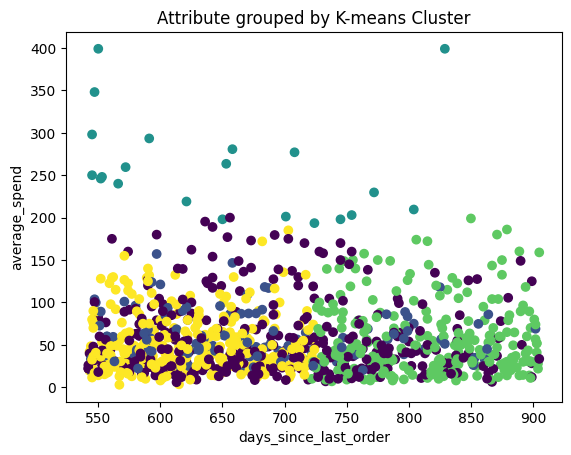

In [10]:
import matplotlib.pyplot as plt


plt.scatter(predictions_df['days_since_last_order'],
            predictions_df['average_spend'],
            c=predictions_df['CENTROID_ID'])
plt.xlabel("days_since_last_order")
plt.ylabel("average_spend")
plt.title("Attribute grouped by K-means Cluster")
plt.show()

In [11]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,55.20,1.33,694.25
1,cluster 2,58.75,3.75,669.44
2,cluster 3,332.54,1.26,692.06
3,cluster 4,54.62,1.30,817.41
4,cluster 5,51.57,1.30,619.30


In [12]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $55.2, count of orders per person 1.33, days since last order 694.25
cluster 2, average spend $58.75, count of orders per person 3.75, days since last order 669.44
cluster 3, average spend $332.54, count of orders per person 1.26, days since last order 692.06
cluster 4, average spend $54.62, count of orders per person 1.3, days since last order 817.41
cluster 5, average spend $51.57, count of orders per person 1.3, days since last order 619.3


In [13]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

In [14]:
model = TextGenerationModel.from_pretrained("text-bison")
response = model.predict(prompt, max_output_tokens=1024, temperature=0.4)
print(response.text)

 **Cluster 1: The Occasional Treaters**

* Persona: These customers are likely to be occasional shoppers who make a purchase when they need something specific. They may not be as brand-loyal as other clusters, and they may be more price-sensitive.
* Next marketing step: Offer a discount or promotion to encourage these customers to make a purchase. You could also try sending them personalized emails with product recommendations based on their past purchases.

**Cluster 2: The Regulars**

* Persona: These customers are likely to be regular shoppers who make purchases on a monthly or quarterly basis. They may be more brand-loyal than other clusters, and they may be willing to pay a premium for quality products.
* Next marketing step: Reward these customers for their loyalty with a loyalty program or exclusive discounts. You could also try sending them personalized emails with product recommendations based on their past purchases.

**Cluster 3: The Big Spenders**

* Persona: These customer

In [15]:
# Delete customer_stats table

client.delete_table(f"{project_id}.{dataset_name}.{table_name}", not_found_ok=True)
print(f"Deleted table: {project_id}.{dataset_name}.{table_name}")


# Delete K-means model
client.delete_model(f"{project_id}.{dataset_name}.{model_name}", not_found_ok=True)
print(f"Deleted model: {project_id}.{dataset_name}.{model_name}")


Deleted table: qwiklabs-gcp-00-ae9536d3c50b.ecommerce.customer_stats
Deleted model: qwiklabs-gcp-00-ae9536d3c50b.ecommerce.customer_segmentation_model
